In [2]:
from read_corpus_functions import load_books_blocks_from_document, load_books_from_document, load_books_chunks_from_document, load_books_from_document_without_residual_ner, trim_documents
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from top2vec import Top2Vec
import umap.plot

/Users/charlottepanuskova/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/charlottepanuskova/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/charlottepanuskova/anaconda3/lib/python3.11/site-packages/uma

In [31]:
path = "data/lem/all"
file_name =   "jerome_synv9_all_blocks_without_residuals_new" #"jerome_synv9_id_no_names_blocks"  "jerome_synv9_id" #_NOV_MEM_COL_deep_learn
file_path = path+"/"+file_name + ".txt"
fiction = True
txtype_select = ['NOV: próza', 'MEM: memoáry, autobiografie', 'COL: kratší próza', 'VER: poezie'] if fiction else [] #
folder = 'whole books  NOV COL MEM VER' if fiction else 'whole books'
file_ending = "_NOV_COL_MEM_VER" if fiction else ''

books, books_info = load_books_from_document(file_path, txtype_select)
u_map_n_neighbours = 15
hdbscan_min_cluster_size = 15
embedding_name = "doc2vec"

save_name = 'top2vec_umap_n_n{}_hdbscan_m_c_s{}_{}_new{}'.format(str(u_map_n_neighbours), str(hdbscan_min_cluster_size), str(embedding_name), file_ending)
df_books_info = pd.read_excel('data/results/top2vec/{}/{}.xlsx'.format(folder, save_name)) 
df_info = pd.read_excel('data/books info/stats/jerome_all_books_info.xlsx')
df_info = df_info[df_info['txtype'].isin(txtype_select)]
df_info.reset_index()
df_books_info.index = df_books_info['Unnamed: 0']
df_books_info = df_books_info.sort_index()
#df_books_info = pd.merge(df_info,df_books_info, on=["title", "author", "publisher"])
df_books_info['tokens'] = df_info['tokens'].to_list()
df_books_info['words'] = df_info['words'].to_list()





In [41]:
# Texts divided into topic categories 
topic_texts = {key: {'title': [], 'author': [], 'documents': [], 'tokens':[], 'number_of_sentences': [], 'words': [], 'average_length_of_sentence': []} for key in np.unique(df_books_info.topic)}

for i, row in df_books_info.iterrows():
    print(i)
    topic_texts[row.topic]['title'].append(row.title)  
    topic_texts[row.topic]['author'].append(row.author)   
    topic_texts[row.topic]['documents'].append(books[i])   
    topic_texts[row.topic]['words'].append(row.words)
    topic_texts[row.topic]['tokens'].append(row.tokens)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Lengths of texts and number of sentences

In [42]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

for topic, value in topic_texts.items(): 
    tokens = []
    sentences = []
    avg_length_sentence = []
    for document, words in zip(value['documents'], value['words']): 
        number_of_sentences = sent_tokenize(document)
        sentences.append(len(number_of_sentences))
        avg_length_sentence.append(words/len(number_of_sentences))
 
    topic_texts[topic]['number_of_sentences'] = sentences
    topic_texts[topic]['average_length_of_sentence'] = avg_length_sentence


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/charlottepanuskova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
for topic, value in topic_texts.items():
    for title, author, avg_sentence, number_sentence, number_words in zip(value['title'], value['author'], value['average_length_of_sentence'],value['number_of_sentences'], value['words']):
        if avg_sentence > 100:
            print('{} - {}:avg_sent_length - {}, number_of_sentences - {}, words - {}'.format(title, author, avg_sentence, number_sentence, number_words) )    

Poselství kulhavého běžce - Komenda, Stanislav:avg_sent_length - 908.3461538461538, number_of_sentences - 52, words - 47234
Ženy, Havel, hygiena - Vaněk-Úvalský, Bohuslav:avg_sent_length - 158.7283950617284, number_of_sentences - 81, words - 12857
Vzpomínky - Čapková, Jarmila:avg_sent_length - 252.65, number_of_sentences - 140, words - 35371
Třinácté komnaty - Kala, Miroslav - Veselý, Jiří Maria:avg_sent_length - 286.07142857142856, number_of_sentences - 28, words - 8010
Jan Bělehrádek a jeho cesta ke svobodě ducha - Linhartová, Věra (ed.):avg_sent_length - 1025.1, number_of_sentences - 80, words - 82008
Víra je můj pevný hrad - Otčenášek, Karel - Svoboda, Bohumil:avg_sent_length - 323.9555555555556, number_of_sentences - 225, words - 72890
Třetí ženou svého muže - Peroutková, Slávka:avg_sent_length - 841.7666666666667, number_of_sentences - 30, words - 25253


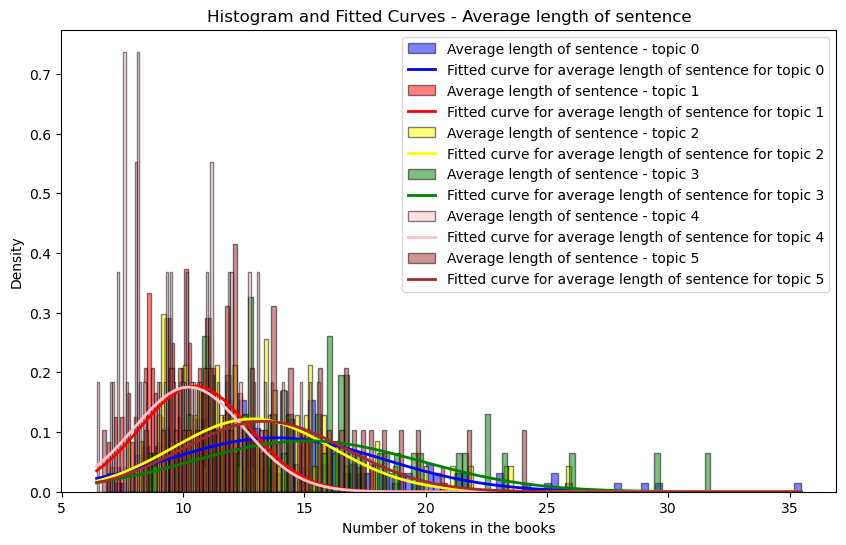

In [49]:
from scipy.stats import norm

column = 'average_length_of_sentence'


filter_values = 45

all_scores = [token for _, value in topic_texts.items() for token in value[column]]
all_scores = list(filter(lambda x: x<filter_values, all_scores))
# Plot overlayed histograms
plt.figure(figsize=(10, 6))


for color, (i, value) in zip(['blue', "red", "yellow", "green", 'pink', 'brown'], topic_texts.items()):
    tokens = value[column]
    tokens = list(filter(lambda x: x<filter_values, tokens))
    counts1, bins1, _ = plt.hist(tokens, bins=100, alpha=0.5, color=color, edgecolor='black', label='Average length of sentence - topic {}'.format(i), density=True)

    # Fit Gaussian distributions to the data
    mu, std = norm.fit(tokens)

    # Plot the fitted curves
    x = np.linspace(min(all_scores), max(all_scores), 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, color, linewidth=2, label='Fitted curve for average length of sentence for topic {}'.format(i))

plt.title('Histogram and Fitted Curves - Average length of sentence')
plt.xlabel('Number of tokens in the books')
plt.ylabel('Density')
plt.legend()